## 趋势跟踪策略


         AnnRet    AnnVol        SR     MaxDD    Calmar
asset   0.09972  0.263065  0.379071 -0.723038  0.137918
stgy   0.121461  0.162562  0.747166 -0.372674  0.325918
         AnnRet    AnnVol        SR     MaxDD    Calmar
asset   0.09972  0.263065  0.379071 -0.723038  0.137918
stgy   0.116306  0.168555   0.69002 -0.480467  0.242069
         AnnRet    AnnVol        SR     MaxDD    Calmar
asset   0.09972  0.263065  0.379071 -0.723038  0.137918
stgy   0.135519  0.160571  0.843983  -0.35179  0.385227
         AnnRet    AnnVol        SR     MaxDD    Calmar
asset  0.100956  0.244424  0.413036 -0.639139  0.157956
stgy   0.082502  0.176235  0.468133 -0.312061  0.264376


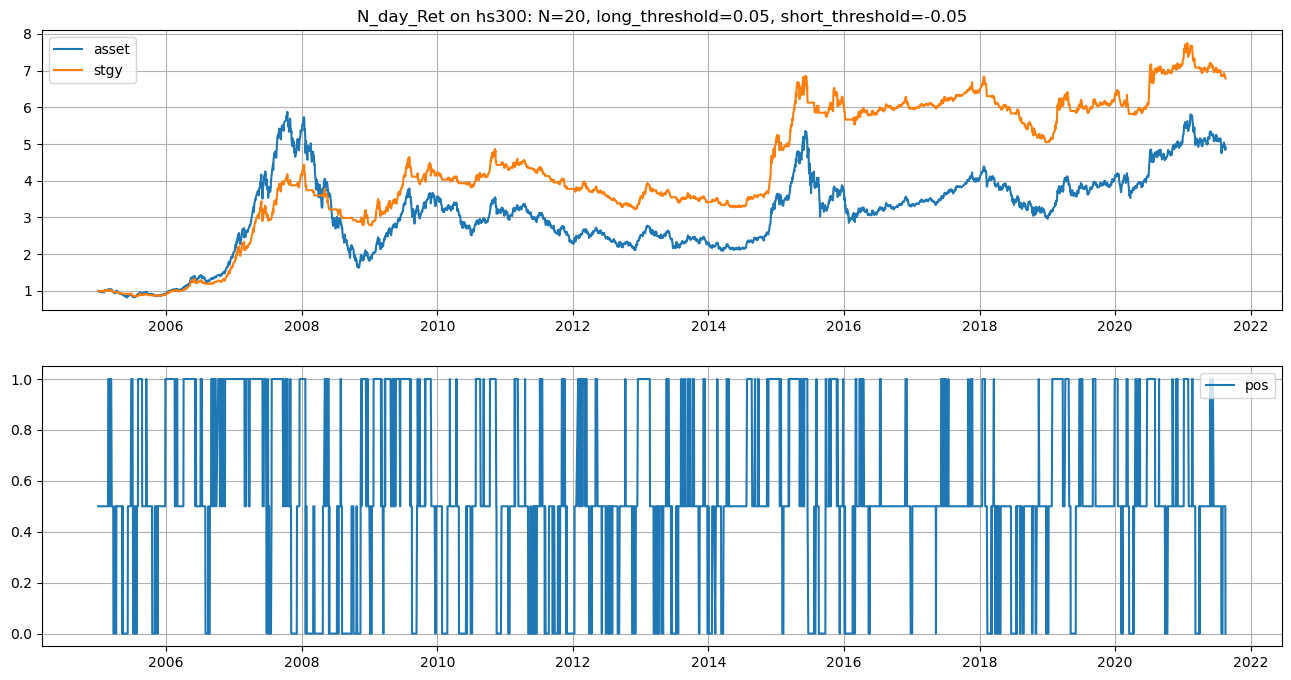

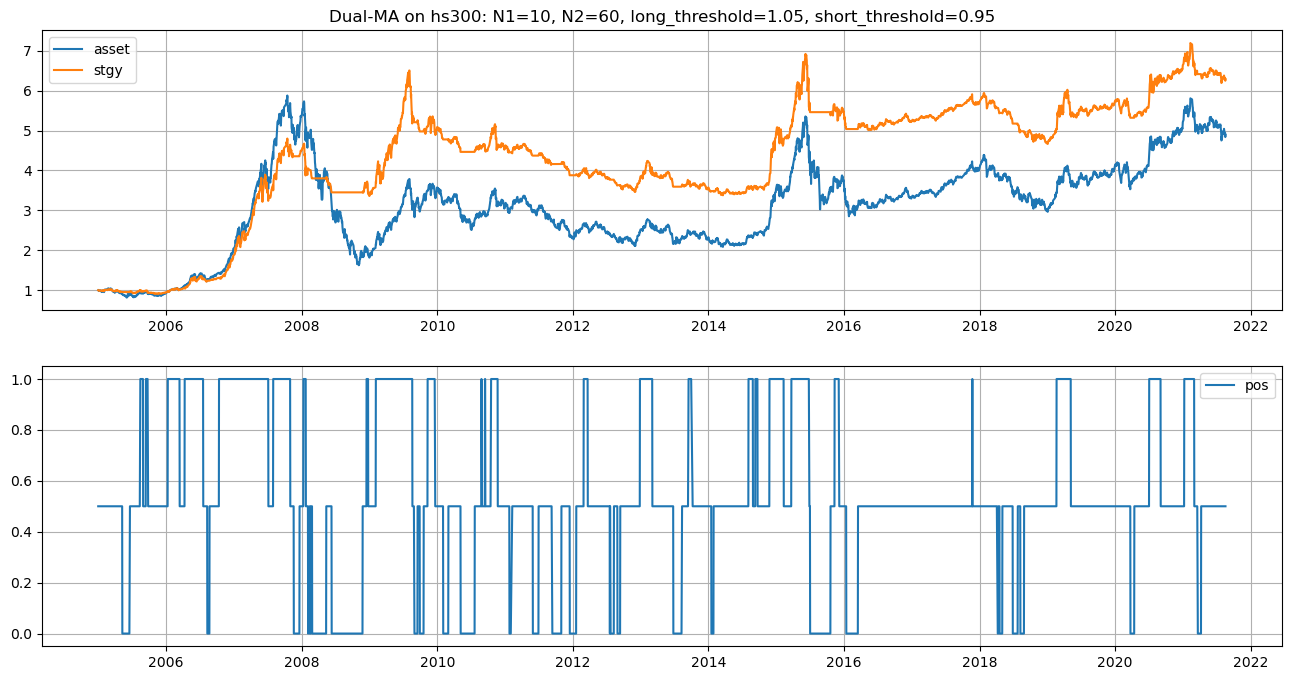

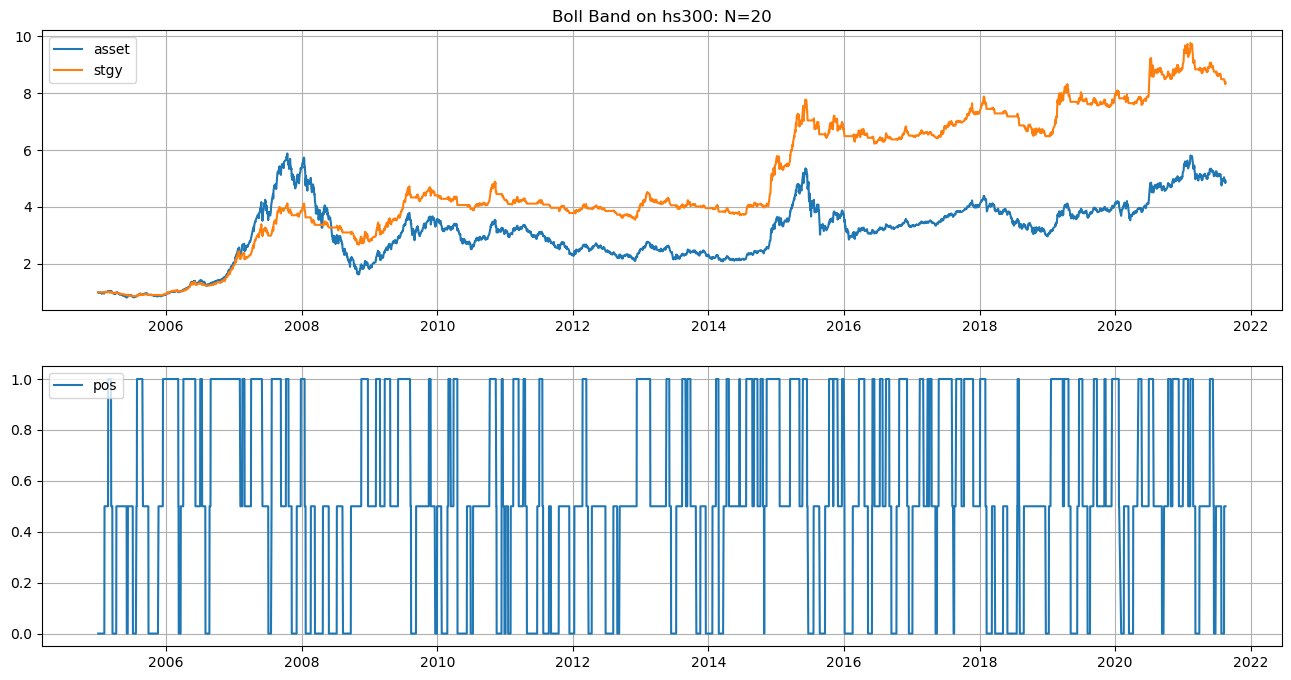

C:\Users\SongKang\.conda\envs\ak\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 34746 (\N{CJK UNIFIED IDEOGRAPH-87BA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\SongKang\.conda\envs\ak\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 32441 (\N{CJK UNIFIED IDEOGRAPH-7EB9}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\SongKang\.conda\envs\ak\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 38050 (\N{CJK UNIFIED IDEOGRAPH-94A2}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


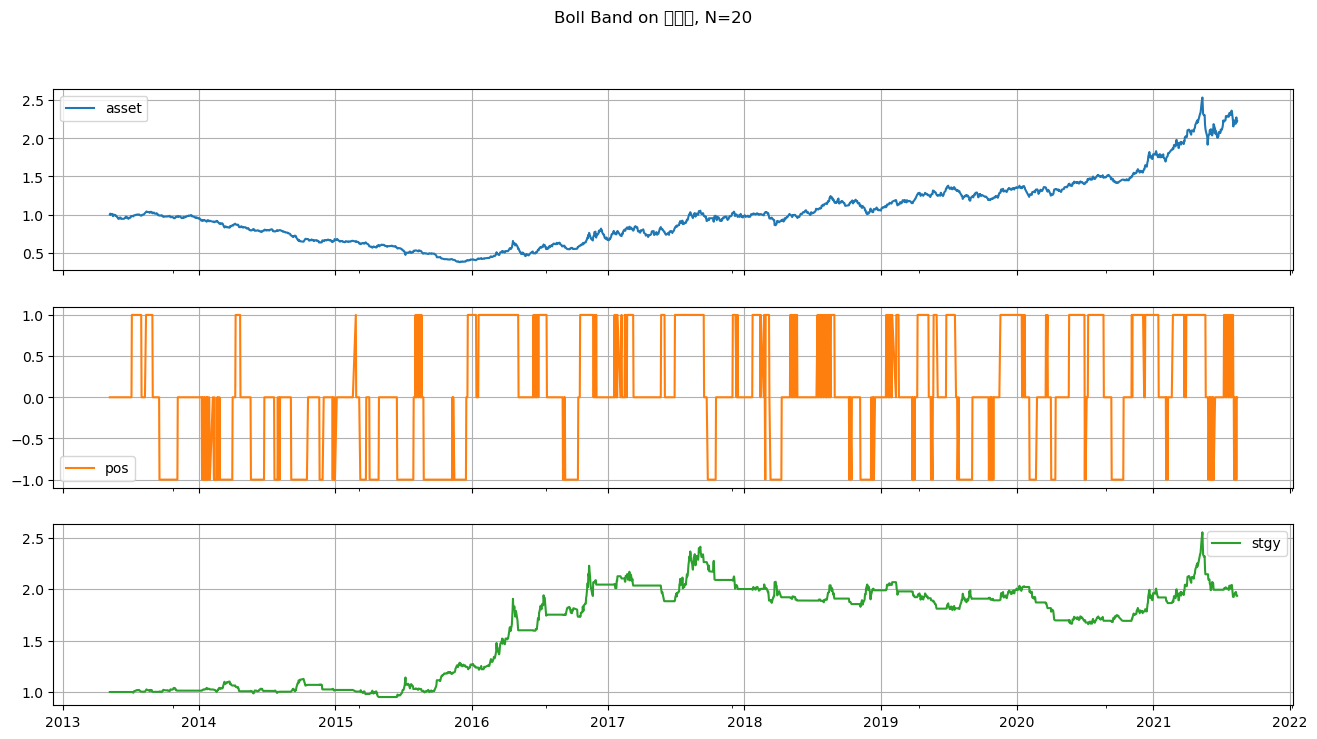

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime

def get_drawdown(p):
    hmax = p.cummax()
    return p / hmax - 1


def cal_period_perf_indicator(adjnav):
    if type(adjnav) == pd.DataFrame:
        res = pd.DataFrame(index=adjnav.columns, columns=['AnnRet', 'AnnVol', 'SR', 'MaxDD', 'Calmar'])
        for col in adjnav:
            res.loc[col] = cal_period_perf_indicator(adjnav[col])
        return res
    ret = adjnav.pct_change()
    #annret = np.nanmean(ret) * 242 # 单利
    annret = (adjnav[-1] / adjnav[0]) ** (242/len(adjnav)) - 1 # 复利
    annvol = np.nanstd(ret) * np.sqrt(242)
    sr = annret / annvol
    dd = get_drawdown(adjnav)
    mdd = np.nanmin(dd)
    calmar = annret / -mdd
    return [annret, annvol, sr, mdd, calmar]


def datestr2dtdate(datestr):
    return datetime.datetime.strptime(datestr, '%Y-%m-%d').date()


index_data = pd.read_csv('四种指数价格历史数据.csv').set_index('datetime')
index_data.index = [datestr2dtdate(e) for e in index_data.index]

################################################################
# 近期涨幅，前一天 >  0.05 就买入
index_id = 'hs300'
N = 20
long_threshold = 0.05
short_threshold = -0.05

df = index_data.loc[:,[index_id]]
df['ret'] = df[index_id].pct_change()
df['asset'] = (1+df['ret']).cumprod().fillna(1)
df['N_day_ret'] = df['asset'] / df['asset'].shift(N) - 1
df['pos'] = [1 if e>long_threshold else 0 if e<short_threshold else 0.5 for e in df['N_day_ret'].shift(1)]
df['stgy_ret'] = df['ret'] * df['pos']
df['stgy'] = (1+df['stgy_ret']).cumprod().fillna(1)

fig = plt.figure(figsize=(16,8))
ax1 = fig.add_subplot(2,1,1)
df.loc[:,['asset','stgy']].plot(ax=ax1, grid=True, title='N_day_Ret on %s: N=%d, long_threshold=%.2f, short_threshold=%.2f' % (index_id, N,long_threshold,short_threshold))
ax2 = fig.add_subplot(2,1,2)
df.loc[:,['pos']].plot(ax=ax2, grid=True)
res = cal_period_perf_indicator(df.loc[:,['asset','stgy']])
print(res)


################################################################
# 双均线系统
index_id = 'hs300'
N1 = 10
N2 = 60
long_threshold = 1.05
short_threshold = 0.95

df = index_data.loc[:,[index_id]]
df['ret'] = df[index_id].pct_change()
df['asset'] = (1+df['ret']).cumprod().fillna(1)
df['ret'] = df['asset'].pct_change()
df['MA1'] = df['asset'].rolling(window=N1).mean()  # rolling()的主要用途为进行移动均值计算，常用来对时间序列数据做均值操作。
df['MA2'] = df['asset'].rolling(window=N2).mean()
df['MA1/MA2'] = df['MA1'] / df['MA2']
df['pos'] = [1 if e>long_threshold else 0 if e<short_threshold else 0.5 for e in df['MA1/MA2'].shift(1)]
df['stgy_ret'] = df['ret'] * df['pos']
df['stgy'] = (1+df['stgy_ret']).cumprod().fillna(1)

fig = plt.figure(figsize=(16,8))
ax1 = fig.add_subplot(2,1,1)
df.loc[:,['asset','stgy']].plot(ax=ax1, grid=True, title='Dual-MA on %s: N1=%d, N2=%d, long_threshold=%.2f, short_threshold=%.2f' % (index_id, N1, N2, long_threshold, short_threshold))
ax2 = fig.add_subplot(2,1,2)
df.loc[:,['pos']].plot(ax=ax2, grid=True)
res = cal_period_perf_indicator(df.loc[:,['asset','stgy']])
print(res)


################################################################
# 布林带
# 中轨=20日均线；
# 上轨=20日均线+2个标准差；
# 下轨=20日均线-2个标准差。
# 标准差可以反映一个数据集的离散程度

N = 20
index_id = 'hs300'

df = index_data.loc[:,[index_id]]
df['ret'] = df[index_id].pct_change()
df['asset'] = (1+df['ret']).cumprod().fillna(1)
df['ret'] = df['asset'].pct_change()
df['MA'] = df['asset'].rolling(window=N).mean()
df['std'] = df['asset'].rolling(window=N).std() # 标准差可以反映一个数据集的离散程度
df['up'] = df['MA'] + 2 * df['std']
df['down'] = df['MA'] - 2 * df['std']
df['pos'] = 0
for i in range(1,len(df)):
    t = df.index[i]
    t0 = df.index[i-1]
    if df.loc[t0,'asset'] > df.loc[t0,'up']:
        df.loc[t,'pos'] = 1
    elif df.loc[t0,'asset'] < df.loc[t0,'down']:
        df.loc[t,'pos'] = 0
    elif df.loc[t0,'pos']==1 and df.loc[t0,'asset']<df.loc[t0,'MA']:
        df.loc[t,'pos'] = 0.5
    elif df.loc[t0,'pos']==0 and df.loc[t0,'asset']>df.loc[t0,'MA']:
        df.loc[t,'pos'] = 0.5
    else:
        df.loc[t,'pos'] = df.loc[t0,'pos']
df['stgy_ret'] = df['ret'] * df['pos']
df['stgy'] = (1+df['stgy_ret']).cumprod().fillna(1)

fig = plt.figure(figsize=(16,8))
ax1 = fig.add_subplot(2,1,1)
df.loc[:,['asset','stgy']].plot(ax=ax1, grid=True, title='Boll Band on %s: N=%d' % (index_id, N))
ax2 = fig.add_subplot(2,1,2)
df.loc[:,['pos']].plot(ax=ax2, grid=True)
res = cal_period_perf_indicator(df.loc[:,['asset','stgy']])
print(res)


#####################################################

# 从csv文件获取期货价格数据
future_data = pd.read_csv('期货主连数据.csv').set_index('datetime')
future_data.index = [datestr2dtdate(e) for e in future_data.index]


# 布林带
N = 20
future_name = '螺纹钢'

df = future_data.loc[:,['close']].rename(columns={'close':'asset'})
df['ret'] = df['asset'].pct_change()
df['MA'] = df['asset'].rolling(window=N).mean()
df['std'] = df['asset'].rolling(window=N).std()
df['up'] = df['MA'] + 2 * df['std']
df['down'] = df['MA'] - 2 * df['std']
df['pos'] = 0
for i in range(2,len(df)):
    t = df.index[i]
    t0 = df.index[i-2]
    if df.loc[t0,'asset'] > df.loc[t0,'up']:
        df.loc[t,'pos'] = 1
    elif df.loc[t0,'asset'] < df.loc[t0,'down']:
        df.loc[t,'pos'] = -1
    elif df.loc[t0,'pos']==1 and df.loc[t0,'asset']<df.loc[t0,'MA']:
        df.loc[t,'pos'] = 0
    elif df.loc[t0,'pos']==-1 and df.loc[t0,'asset']>df.loc[t0,'MA']:
        df.loc[t,'pos'] = 0
    else:
        df.loc[t,'pos'] = df.loc[t0,'pos']
df['stgy_ret'] = df['ret'] * df['pos']
df['stgy'] = (1+df['stgy_ret']).cumprod().fillna(1)
df.loc[:,['asset', 'pos', 'stgy']].plot(figsize=(16,8), subplots=True, grid=True, title='Boll Band on %s, N=%d' % (future_name,N))
res = cal_period_perf_indicator(df.loc[:,['asset', 'stgy']])
print(res)

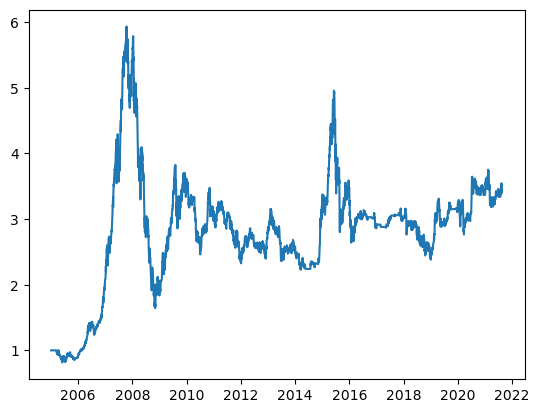

In [6]:
import numpy as np
import pandas as pd
import talib
import datetime

def datestr2dtdate(datestr):
    return datetime.datetime.strptime(datestr, '%Y-%m-%d').date()


# 获取数据

df = pd.read_csv('四种指数价格历史数据.csv').set_index('datetime')
df.index = [datestr2dtdate(e) for e in df.index]

# 计算布林带
close = df['hs300'].values
upper, middle, lower = talib.BBANDS(close, timeperiod=20, nbdevup=2, nbdevdn=2)

# 计算布林带宽度
bandwidth = (upper - lower) / middle

# 设置阈值和交易信号
threshold = 0.05  # 布林带宽度阈值
signal = np.zeros(len(df))  # 交易信号，1为买入，-1为卖出

for i in range(1, len(df)):
    if bandwidth[i] > threshold and bandwidth[i-1] <= threshold:
        signal[i] = 1
    elif bandwidth[i] < threshold and bandwidth[i-1] >= threshold:
        signal[i] = -1

# 执行交易
position = 0  # 当前持仓
for i in range(len(df)):
    if signal[i] == 1 and position == 0:
        # 买入
        position = 1
    elif signal[i] == -1 and position == 1:
        # 卖出
        position = 0

    # 记录每天的持仓情况
    df.loc[df.index[i], 'position'] = position

# 计算收益
df['pnl'] = df['hs300'].pct_change() * df['position'].shift(1)
df['cum_pnl'] = (1 + df['pnl']).cumprod()

# 绘制收益曲线
import matplotlib.pyplot as plt

plt.plot(df['cum_pnl'])
plt.show()